#Part-B [15 points]: Multiclass App Review Classification: from scratch

Dataset analysis and report on important statistics.

,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others


Shape: 2900 rows, 2 columns

Data types:
review    object
Label     object
dtype: object

Missing values per column:
review    0
Label     0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
       review_length
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000

Class distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64
Label
rating                 0.447586
bug_report             0.260690
improvement_request    0.152414
others                 0.139310
Name: proportion, dtype: float64


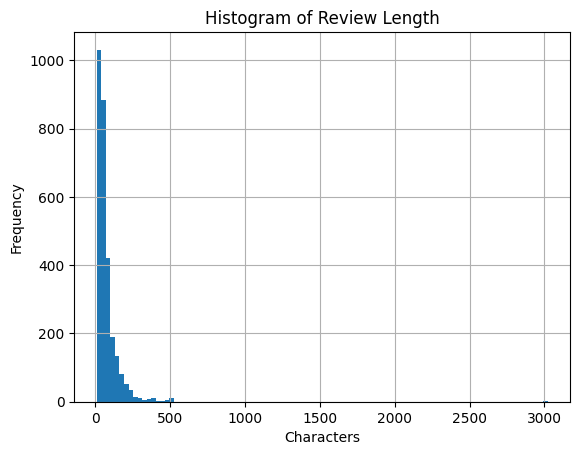

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')
display(df.head())
# # Print the dataset’s shape and a preview of the first rows.
# print(df.shape)
# # Show data types, non-null counts, and missing-value totals.
# # check if thier is null data
# print(df.isnull().sum())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
print(df['Label'].value_counts())
# view class balance as precentage
print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

# we have a review with 3023 charecters, we could remove!

In [3]:
!pip install --upgrade numpy
!pip install --upgrade gensim
!clear

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 254.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

Train the word embeddings from scratch

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# 2) Preprocessing
texts = df['review'].astype(str).tolist()
labels = df['Label'].tolist()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=777
)

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                          maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_LEN, padding='post')

# Model A: embeddings from scratch + Bi-LSTM
model_scratch = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense( len(le.classes_), activation='softmax')
])
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_scratch.summary()

# Train Model A
history_a = model_scratch.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=5,
    batch_size=64
)

# Evaluation & report
def eval_and_report(model, seq, true_y, label_encoder):
    preds = np.argmax(model.predict(seq), axis=1)
    print(classification_report(true_y, preds,
          target_names=label_encoder.classes_))
    cm = confusion_matrix(true_y, preds)
    print("Confusion matrix:\n", cm)

print("=== Model A (scratch) ===")
eval_and_report(model_scratch, val_seq, y_val, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4277 - loss: 1.2910 - val_accuracy: 0.4517 - val_loss: 1.2130
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5166 - loss: 1.1539 - val_accuracy: 0.4914 - val_loss: 1.1304
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6543 - loss: 0.9063 - val_accuracy: 0.6224 - val_loss: 0.9284
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7932 - loss: 0.5566 - val_accuracy: 0.6224 - val_loss: 0.9790
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9216 - loss: 0.3164 - val_accuracy: 0.6190 - val_loss: 1.0339
=== Model A (scratch) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
                     precision    recall  f1-score   support

         bug_report       0.62      0.70      0.66       151
improvement_request       0.43      0.42      0.42        88
             others       0.38      0.40      0.39        81
             rating       0.77      0.71      0.74       26

Use precomputed embeddings (similar to word2vec or Glove for Arabic)

In [8]:
# Download via terminal commands
!wget "https://archive.org/download/aravec2.0/tweet_cbow_300.zip"
!unzip "tweet_cbow_300.zip.1"

Archive:  tweet_cbow_300.zip.1
  inflating: tweets_cbow_300         
  inflating: tweets_cbow_300.trainables.syn1neg.npy  
  inflating: tweets_cbow_300.wv.vectors.npy  


In [16]:
import numpy as np
import gensim
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

# 1) Load your pre‐trained Word2Vec model
w2v_model = gensim.models.Word2Vec.load('tweets_cbow_300')

# 2) Cleaning / normalizing function (as you provided)
import re
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",
              '"',"ـ","'","ى","\\",'\n','\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","","ي","",' ',' ',' ',' ? ',' ؟ ',' ! ']
    # remove tashkeel
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', "", text)
    # collapse repeated chars
    text = re.sub(r'(.)\1+', r"\1\1", text)
    # simple normalizations
    text = text.replace('وو','و').replace('يي','ي').replace('اا','ا')
    for s, r in zip(search, replace):
        text = text.replace(s, r)
    return text.strip()

# 3) Apply cleaning before tokenization
X_train = [ clean_str(t) for t in X_train ]
X_val   = [ clean_str(t) for t in X_val ]

# (re‐tokenize & pad your sequences here, if needed)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),   maxlen=MAX_LEN, padding='post')

# 4) Build the embedding matrix from the gensim model
embed_dim   = w2v_model.vector_size
word_index  = tokenizer.word_index
num_tokens  = min(332000, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embed_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # OOV words: you can leave as zeros or random‐initialize
        embedding_matrix[i] = np.random.normal(size=(embed_dim,))

# 5) Define & compile Model B using these embeddings
model_pretrained = Sequential([
    Embedding(
        input_dim=num_tokens,
        output_dim=embed_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_pretrained.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_pretrained.summary()

# 6) Train & evaluate
history_b = model_pretrained.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=5,
    batch_size=64
)

print("\n=== Model B (pre-trained embeddings) ===")
eval_and_report(model_pretrained, val_seq, y_val, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     3,106,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,106,200 (11.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,106,200 (11.85 MB)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4365 - loss: 1.2418 - val_accuracy: 0.6466 - val_loss: 0.9630
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6646 - loss: 0.9100 - val_accuracy: 0.6776 - val_loss: 0.8439
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7042 - loss: 0.7878 - val_accuracy: 0.6966 - val_loss: 0.8006
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7667 - loss: 0.6436 - val_accuracy: 0.7121 - val_loss: 0.7730
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7989 - loss: 0.5525 - val_accuracy: 0.7069 - val_loss: 0.7708

=== Model B (pre-trained embeddings) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
                     precision    recall  f1-score   support

         bug_report       0.82      0.59      0.68       151
improvement_request       0.56      0.52      0.54        88
             others       0.53      0.72      0.61        81
             rating       0.78      0.83   

Classification analysis and possible improvements.

# Possible improvements
"""
- **Hyperparameter tuning:** grid-search over LSTM hidden units, dropout rate, learning rate.
- **Stacked RNNs or GRU:** try 2-layer LSTM/GRU or switch to GRU for faster training.
- **Bidirectional & Attention:** add an attention layer on top of the RNN outputs.
- **Fine-tuning embeddings:** set trainable=True for the Embedding layer in Model B.
- **Data augmentation:** back-translation or synonym replacement on reviews.
- **Class imbalance handling:** use class_weights or focal loss if your label counts are skewed.
- **Ensemble:** average predictions of multiple architectures.
"""

#Part-C [15 points]: Multilabel App Review Classification: from scratch

Dataset analysis and report on important statistics.

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1


Shape: 2900 rows, 5 columns

Data types:
review                 object
bug_report              int64
improvement_request     int64
rating                  int64
others                  int64
dtype: object

Missing values per column:
review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
        bug_report  improvement_request       rating       others  \
count  2900.000000          2900.000000  2900.000000  2900.000000   
mean      0.401379             0.380345     0.679655     0.282759   
std       0.490262             0.485555     0.466690     0.450418   
min       0.000000             0.000000     0.000000     0.000000   
25%       0.000000             0.000000     0.000000    

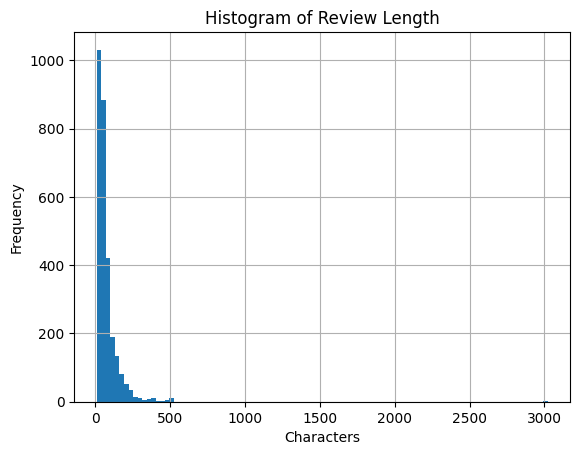

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-Multilabel.csv')
display(df.head())
# # Print the dataset’s shape and a preview of the first rows.
# print(df.shape)
# # Show data types, non-null counts, and missing-value totals.
# # check if thier is null data
# print(df.isnull().sum())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
bug_report_counts = df['bug_report'].sum()
improvement_request_counts = df['improvement_request'].sum()
rating_counts = df['rating'].sum()
others_counts = df['others'].sum()
print(bug_report_counts,"bug_report")
print(improvement_request_counts,"improvement_request")
print(rating_counts,"rating")
print(others_counts,"others")

# viewing class balance as precentage
total_sum = bug_report_counts + improvement_request_counts + rating_counts + others_counts
print("As precentages")
print((bug_report_counts/total_sum)*100,"%","bug_report")
print((improvement_request_counts/total_sum)*100,"%","improvement_request")
print((rating_counts/total_sum)*100,"%","rating")
print((others_counts/total_sum)*100,"%","others")
#print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

# we have a review with 3023 charecters, we could remove!

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

In [37]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    hamming_loss,
    accuracy_score
)

def eval_and_report_multilabel(model, seq, true_y, label_names, threshold=0.5):
    # 1) Predict probabilities and binarize
    preds_proba = model.predict(seq)
    preds = (preds_proba >= threshold).astype(int)

    # 2) Per‐label reports
    print("=== Per-Label Classification Reports ===")
    for i, name in enumerate(label_names):
        print(f"\n>> Label: {name}")
        print(classification_report(
            true_y[:, i],
            preds[:, i],
            target_names=['negative', 'positive'],
            zero_division=0))
        print("Confusion matrix:")
        print(confusion_matrix(true_y[:, i], preds[:, i]))

    # 3) Overall multilabel metrics
    print("\n=== Overall Multilabel Metrics ===")
    print(f"Hamming Loss:    {hamming_loss(true_y, preds):.4f}")
    print(f"Subset Accuracy: {accuracy_score(true_y, preds):.4f}")

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# 2) Identify text & one-hot columns
text_col   = 'review'
label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]

# 3) Prepare X and y
texts = df[text_col].astype(str).tolist()
y     = df[label_cols].values             # shape (n_samples, 4)
y_int = np.argmax(y, axis=1)              # integer labels for metrics/stratify

# 4) Decide whether we can stratify
counts = np.bincount(y_int)
strat_arg = y_int if counts.min() >= 2 else None

# 5) Split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2,
    stratify=strat_arg,
    random_state=777
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15,
    random_state=777
)


# 6) Tokenize & pad
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 7) Build & compile the model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(label_cols), activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

# 8) Train
history = model.fit(
    train_seq, np.array(y_train),
    validation_data=(val_seq, np.array(y_val)),
    epochs=25, batch_size=64
)

eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.3127 - loss: 2.5284 - val_accuracy: 0.3448 - val_loss: 2.4132
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2870 - loss: 3.1836 - val_accuracy: 0.3448 - val_loss: 2.5049
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2894 - loss: 3.4510 - val_accuracy: 0.3448 - val_loss: 2.5454
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3192 - loss: 3.3872 - val_accuracy: 0.3448 - val_loss: 2.5015
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3045 - loss: 3.4082 - val_accuracy: 0.3448 - val_loss: 2.4858
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3040 - loss: 3.2984 - val_accuracy: 0.3448 - val_loss: 2.4670
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2906 - loss: 3.3567 - val_accuracy: 0.3448 - val_loss: 2.5097
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2930 - loss: 3.3444 - val_accuracy: 0.3448 - v

You can use the best embedding from Part-B

Classification analysis and possible improvements.

Total samples: 2900
Labels: ['bug_report', 'improvement_request', 'rating', 'others']

Label frequencies:
rating                 1971
bug_report             1164
improvement_request    1103
others                  820
dtype: int64

Labels per review:
1    1293
2    1098
3     467
4      42
Name: count, dtype: int64

Loaded tokenizer from disk.

Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "multilabel_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 600, 300)       │    99,503,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,959,704 (381.32 MB)

 Trainable params: 456,004 (1.74 MB)

 Non-trainable params: 99,503,700 (379.58 MB)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3393 - loss: 0.6528 - val_accuracy: 0.3039 - val_loss: 0.6074
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4039 - loss: 0.5721 - val_accuracy: 0.4116 - val_loss: 0.5743
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4905 - loss: 0.5081 - val_accuracy: 0.4289 - val_loss: 0.5501
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5625 - loss: 0.4266 - val_accuracy: 0.4353 - val_loss: 0.5509
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5622 - loss: 0.3749 - val_accuracy: 0.4849 - val_loss: 0.5511
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6092 - loss: 0.2806 - val_accuracy: 0.4461 - val_loss: 0.5987
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6157 - loss: 0.2297 - val_accuracy: 0.4871 - val_loss: 0.6176
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6081 - loss: 0.1875 - val_accuracy: 0.5108 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


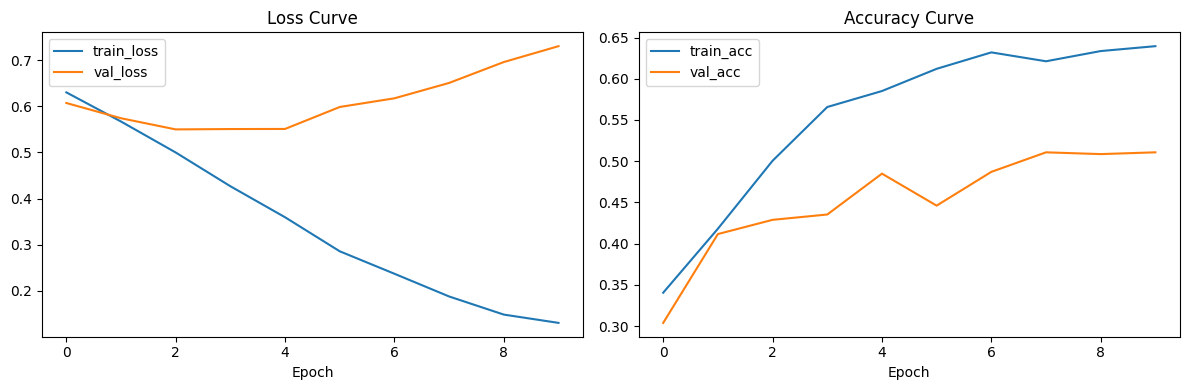

In [5]:
  # app_review_multilabel_pipeline.py
  import numpy as np
  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import classification_report
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from tensorflow.keras.preprocessing.text import Tokenizer
  from tensorflow.keras.preprocessing.sequence import pad_sequences
  from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
  from tensorflow.keras.models import Model
  import pickle

  # 1) LOAD DATASET
  DATA_PATH = 'App Reviews-Multilabel.csv'              # your CSV file
  df = pd.read_csv(DATA_PATH)
  print(f'Total samples: {len(df)}')

  # Identify label columns
  TEXT_COL = 'review'
  label_cols = [c for c in df.columns if c != TEXT_COL]
  print('Labels:', label_cols)

  # 2) DATASET ANALYSIS
  # a) Label counts
  counts = df[label_cols].sum().sort_values(ascending=False)
  print('\nLabel frequencies:')
  print(counts)

  # b) Labels per sample
  labels_per_sample = df[label_cols].sum(axis=1).value_counts().sort_index()
  print('\nLabels per review:')
  print(labels_per_sample)

  # 3) TEXT PREPROCESSING
  # — Load tokenizer from Part B (if you saved it), otherwise fit a new one:
  TOKENIZER_PATH = 'tokenizer.pickle'
  MAX_NUM_WORDS = 20000
  MAX_SEQ_LEN    = 600

  try:
      with open(TOKENIZER_PATH, 'rb') as f:
          tokenizer = pickle.load(f)
      print('\nLoaded tokenizer from disk.')
  except FileNotFoundError:
      print('\nTokenizer not found — fitting a new one.')
      tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
      tokenizer.fit_on_texts(df[TEXT_COL])
      with open(TOKENIZER_PATH, 'wb') as f:
          pickle.dump(tokenizer, f)

  # Convert texts to padded sequences
  sequences = tokenizer.texts_to_sequences(df[TEXT_COL].astype(str))
  X = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

  # Prepare label array
  y = df[label_cols].values.astype(int)

  # Split train/test
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=777, stratify=(y.sum(axis=1)>=1)
  )
  X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=777, stratify=(y_train.sum(axis=1)>=1)
  )


  # 4) EMBEDDING MATRIX LOADING
  # Assumes you exported embedding_matrix.npy from Part B
  EMBEDDING_PATH = '/content/tweets_cbow_300.wv.vectors.npy'
  embedding_matrix = np.load(EMBEDDING_PATH)
  print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

  # 5) BUILD RNN-BASED MULTILABEL MODEL
  vocab_size, embedding_dim = embedding_matrix.shape
  num_labels = y_train.shape[1]

  inputs = Input(shape=(MAX_SEQ_LEN,), name='input')
  x = Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      weights=[embedding_matrix],
      input_length=MAX_SEQ_LEN,
      trainable=False,
      name='embedding'
  )(inputs)

  # Bidirectional LSTM encoder
  x = Bidirectional(LSTM(128, return_sequences=False,recurrent_dropout=0.2), name='bilstm')(x)
  x = Dropout(0.3, name='dropout_1')(x)

  # Dense layers
  x = Dense(64, activation='relu', name='dense_1')(x)

  x = Dropout(0.3, name='dropout_2')(x)

  outputs = Dense(num_labels, activation='sigmoid', name='output')(x)

  model = Model(inputs, outputs, name='multilabel_rnn')
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  model.summary()

  # 6) TRAIN
  EPOCHS = 10
  BATCH_SIZE = 32

  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=EPOCHS,
      batch_size=BATCH_SIZE
  )

  # 7) EVALUATION
  # Predict on validation set with 0.5 threshold
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob >= 0.5).astype(int)

  print('\nClassification Report:')
  print(classification_report(y_test, y_pred, target_names=label_cols))

  # 8) PLOT TRAINING CURVES
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Loss Curve'); plt.xlabel('Epoch'); plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label='train_acc')
  plt.plot(history.history['val_accuracy'], label='val_acc')
  plt.title('Accuracy Curve'); plt.xlabel('Epoch'); plt.legend()

  plt.tight_layout()
  plt.show()


#Part-D [15 points]: Multiclass App Review Classification: Finetune an MLM


Fine-tune a Bert-type model like Arabert or Marbert

In [20]:
# install the AraBERT preprocessor
!pip install arabert

# install Farasa (required by the preprocessor for v1 & v2 tokenization)
!pip install farasapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 14.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=8a29070d8bfd573bbcc5242f8abcd07b4cc0ff7fdbd62b474bad29f52ebb4f72
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


Token indices sequence length is longer than the specified maximum sequence length for this model (1008 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


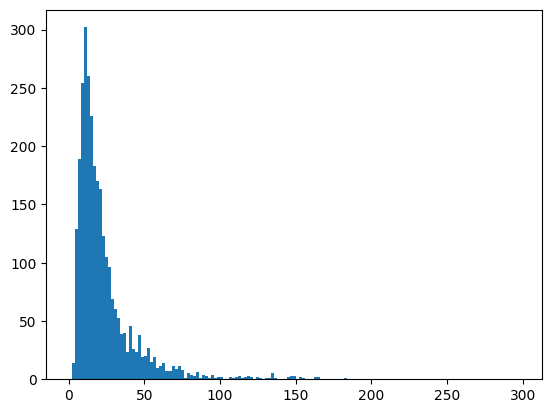

In [30]:
tok = AutoTokenizer.from_pretrained('aubmindlab/bert-large-arabertv2')
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in df['review'].to_list()],bins=range(0,300,2))
plt.show()

In [31]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > 200 for sentence in df['review'].to_list()]))

Truncated training sequences:  1


In [35]:
# fine_tune_bert_multiclass.py
from arabert.preprocess import ArabertPreprocessor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# 1) LOAD DATA
DATA_PATH = 'App Reviews-SingleLabel-Multiclass.csv'
df = pd.read_csv(DATA_PATH)

# Assume columns: 'review' (text) and 'label' (int 0..N-1)
label_names = sorted(df['Label'].unique())
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
label_names = list(le.classes_)   # e.g. ['bug', 'feature', 'rating', 'other']
num_labels = len(label_names)

arabic_prep = ArabertPreprocessor('aubmindlab/bert-large-arabertv2')
df['review'] = df['review'].apply(lambda x: arabic_prep.preprocess(x))

# 2) TRAIN/VAL SPLIT
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=777)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['Label'], random_state=777)
# 3) DATASET CLASS
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 4) TOKENIZER & DATASETS
MODEL_NAME = 'aubmindlab/bert-large-arabertv2'  # or 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(
    train_df['review'].tolist(),
    train_df['Label'].tolist(),
    tokenizer
)
val_ds = ReviewDataset(
    val_df['review'].tolist(),
    val_df['Label'].tolist(),
    tokenizer
)
test_ds = ReviewDataset(
    test_df['review'].tolist(),
    test_df['Label'].tolist(),
    tokenizer
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 5) MODEL
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# 6) TRAINING ARGUMENTS
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./bert_reviews',
    overwrite_output_dir=True,

    # enable training & evaluation
    do_train=True,
    do_eval=True,

    # run eval and saving at the end of each epoch
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,        # keep only the best/last checkpoint

    # core hyperparameters
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,

    # log every 100 steps
    logging_strategy='steps',
    logging_steps=100,

    # pick up the best model automatically
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)




# 7) METRICS
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        **{f'{lab}_f1': score
           for lab, score in
           zip(label_names,
               __import__('sklearn.metrics').metrics.f1_score(
                   labels, preds, average=None
               ))
        }
    }

# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,        # ← pad to max length in each batch
    compute_metrics=compute_metrics
)

# 9) RUN TRAINING
trainer.train()

# 10) EVALUATION
metrics = trainer.evaluate()
print(metrics)

# 11) DETAILED REPORT
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print(classification_report(val_df['Label'], preds, target_names=[str(l) for l in label_names]))


[2025-05-09 19:54:47,025 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-2be9b4420bea>:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Bug Report F1,Improvement Request F1,Others F1,Rating F1
1,0.975500,0.633800,0.798851,0.793651,0.699029,0.729412,0.852665
2,0.582800,0.610605,0.778736,0.771574,0.699029,0.659341,0.845902
3,0.395400,0.638114,0.798851,0.820225,0.698113,0.681319,0.853583


{'eval_loss': 0.6337999105453491, 'eval_accuracy': 0.7988505747126436, 'eval_bug_report_f1': 0.7936507936507936, 'eval_improvement_request_f1': 0.6990291262135923, 'eval_others_f1': 0.7294117647058823, 'eval_rating_f1': 0.8526645768025078, 'eval_runtime': 2.5058, 'eval_samples_per_second': 138.879, 'eval_steps_per_second': 4.39, 'epoch': 3.0}
                     precision    recall  f1-score   support

         bug_report       0.77      0.82      0.79        91
improvement_request       0.72      0.68      0.70        53
             others       0.84      0.65      0.73        48
             rating       0.83      0.87      0.85       156

           accuracy                           0.80       348
          macro avg       0.79      0.76      0.77       348
       weighted avg       0.80      0.80      0.80       348



Classification analysis and possible improvements.

#Part-E [15 points]: Multilabel App Review Classification: Finetune an MLM

Fine-tune a Bert-type model like Arabert or Marbert

In [37]:
# fine_tune_bert_multilabel.py

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# 1) LOAD & SPLIT
DATA_PATH = 'App Reviews-Multilabel.csv'
df = pd.read_csv(DATA_PATH)

TEXT_COL = "review"
LABEL_COLS = ['bug_report','improvement_request','rating','others']
num_labels = len(LABEL_COLS)

# ensure label columns are ints 0/1
df[LABEL_COLS] = df[LABEL_COLS].astype(int)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42,
    stratify=df[LABEL_COLS].sum(axis=1)
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42,
    stratify=train_df[LABEL_COLS].sum(axis=1)
)

# 2) OPTIONAL: AraBERT preprocessing (if desired)
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-base-arabertv2')
for df_ in (train_df, val_df, test_df):
    df_['review'] = df_['review'].apply(prep.preprocess)

# 3) DATASET
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels.astype(float)    # for BCEWithLogitsLoss
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # tokenize + truncate
        enc = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            truncation=True,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# 4) TOKENIZER & DATASETS
MODEL_NAME = 'aubmindlab/bert-base-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(train_df[TEXT_COL].tolist(),
                         train_df[LABEL_COLS].values,
                         tokenizer)
val_ds   = ReviewDataset(val_df[TEXT_COL].tolist(),
                         val_df[LABEL_COLS].values,
                         tokenizer)
test_ds  = ReviewDataset(test_df[TEXT_COL].tolist(),
                         test_df[LABEL_COLS].values,
                         tokenizer)

data_collator = DataCollatorWithPadding(tokenizer)

# 5) MODEL (multilabel)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # triggers BCEWithLogitsLoss
)

# 6) TRAINING ARGS
training_args = TrainingArguments(
    output_dir="./bert_multilabel",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=3,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
)

# 7) METRICS
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    subset_acc = accuracy_score(labels, preds)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "subset_accuracy": subset_acc
    }

# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 9) TRAIN & EVAL
trainer.train()
print(trainer.evaluate())

# 10) FINAL TEST REPORT
preds_output = trainer.predict(test_ds)
probs = torch.sigmoid(torch.tensor(preds_output.predictions)).numpy()
preds = (probs >= 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(
    test_df[LABEL_COLS].values, preds, target_names=LABEL_COLS
))

[2025-05-09 20:06:32,335 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-37-f171fb33ebdf>:128: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Subset Accuracy
1,0.532200,0.432641,0.762416,0.702462,0.456897
2,0.387400,0.400496,0.790155,0.764399,0.521552
3,0.333400,0.399518,0.790698,0.760845,0.521552


{'eval_loss': 0.39951831102371216, 'eval_micro_f1': 0.7906976744186046, 'eval_macro_f1': 0.7608448837448979, 'eval_subset_accuracy': 0.521551724137931, 'eval_runtime': 0.5169, 'eval_samples_per_second': 448.856, 'eval_steps_per_second': 15.478, 'epoch': 3.0}
                     precision    recall  f1-score   support

         bug_report       0.91      0.82      0.86       236
improvement_request       0.80      0.67      0.73       215
             rating       0.89      0.91      0.90       395
             others       0.79      0.52      0.63       164

          micro avg       0.86      0.77      0.82      1010
          macro avg       0.85      0.73      0.78      1010
       weighted avg       0.86      0.77      0.81      1010
        samples avg       0.90      0.83      0.84      1010



Classification analysis and possible improvements.

#Part-F [15 points]: Multiclass App Review Classification: In-Context learning using causal LLM

Use a causal LLM like GPT or DeepSeek

Zero-shot learning: Design an effective prompt for the task.

o Show the process on multiple prompts by evaluating them on randomly selected 100 samples from the validation set.

o Design the prompts in English and Arabic and compare their performance.

o Select the best prompt design.

o [BONUS] Study the impact of ideas such as informing the model about the
class distribution (based on training data), chain-of-thought, etc.


Few-shot learning: Perform few-shot learning by designing an effective prompt
for the task:

o Select different number of demonstration examples from the training set
and evaluate the performance on the validation set. Plot the performance to
select the best configuration.

o [BONUS] Random demonstration examples vs. selecting demonstration
examples based on some criteria such as similarity and class labels.

o [BONUS] Study the impact of ideas such as ordering of demonstration
based on some criteria vs. random ordering.


#Part-G [15 points]: Multilabel App Review Classification: In-Context learning using causal LLM


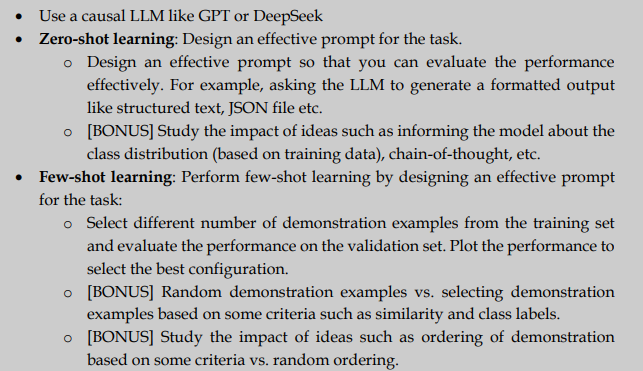